# **04 - Modelling and Evaluation**

## Objectives

* Augment the training dataset to provide the model more data to train on.
* Build a model architecture based on a convolutional neural network, that outputs a probability for a given leaf having powdery mildew or not.
* Fit the model to the training data.
* Evaluate the model performance on the test data.
* Evaluate the model performance on the train, validation and test data using confusion matrix and classification report.
* Evaluate the significans of the probability assigned to the predicted classes, to review if it is a good measure of how likely the prediction is to be correct.

## Inputs

* inputs/cherry_leaves_dataset/cherry-leaves/train
* inputs/cherry_leaves_dataset/cherry-leaves/validation

## Outputs

* Pickle file to store image size for model training.
* Plot indicating the training history expressed in loss and accuracy.
* A CNN machine learning model stored as an .h5 file.
* Pickle file to store accuracy and loss valus from test data evaluation.
* Pickle file to store information on the probability metrics investigated.
* Distribution plots showing the distribution of false predictions next to all predictions for train, validation and test data.

## Additional Comments

* No additional comments. 



---

# Import libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import joblib

from matplotlib.image import imread

---

# Set Data directory variables

## Change working directory

* Change the working directory from the current folder to /workspace/Mildew-Detection-in-Cherry-Leaves

* The output from the cell bellow should be '/workspace/Mildew-Detection-in-Cherry-Leaves'

In [2]:
os.chdir(os.path.dirname(os.getcwd()))
current_dir = os.getcwd()
current_dir

'/workspace/Mildew-Detection-in-Cherry-Leaves'

## Input directory variables

In [3]:
data_dir = 'inputs/cherry_leaves_dataset/cherry-leaves'
train_data_dir = data_dir + '/train'
val_data_dir = data_dir + '/validation'
test_data_dir = data_dir + '/test'

## Output directory variables

In [4]:
# declare the name of your output folder
output_dir = 'current_output'

In [5]:
if 'outputs' not in os.listdir(current_dir):
    os.makedirs(name='outputs')

def create_output_dir(output_dir):
    try:
        os.makedirs(name=f'outputs/{output_dir}')
        print(f'Current output folder is {output_dir} in outputs directory.')
        return f'outputs/{output_dir}'
    except:
        print(f'Current output folder is {output_dir} in outputs directory. Note that this is an already existing folder.')
        return f'outputs/{output_dir}'
version_output = create_output_dir(output_dir)

Current output folder is current_output in outputs directory. Note that this is an already existing folder.


## Data label names variables

In [6]:
labels = os.listdir(train_data_dir)
print(f'Datalabels are {labels}')

Datalabels are ['healthy', 'powdery_mildew']


---

# Augment data

## Set image shape

* As seen in notebook "01 - DataCollection" all images are 256 X 256 pixels 

* To control model performance/model size this model_shape variable might need to be set based on trial and error.

In [7]:
import pickle

#As images are squares (checked in data collection notebook), we set only one variable to control both height and width
height_width = 100
#channel value set to 3 corresponding with RGB
channels = 3

img_shape = (height_width, height_width, channels)

#Store image shape in pickle file for model deployment
with open('/workspace/Mildew-Detection-in-Cherry-Leaves/outputs/current_output/image_size.pkl', 'wb') as file:
    pickle.dump(img_shape, file)

img_shape

(100, 100, 3)

## Set image transformations

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
#Set data augmentation metrics
augment_training_data = ImageDataGenerator(rotation_range=90,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.2,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

### Create data objects for model input

In [10]:
batch_size = 20
#Create augmented training data object for model input
augmented_training_data = augment_training_data.flow_from_directory(train_data_dir,
                                                     target_size=img_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='categorical',
                                                     shuffle=True
                                                     )

augmented_training_data.class_indices

Found 2948 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

In [11]:
#Create training data object for model input, without image transformations
#Used in model evaluation to only evaluate on "Authentic" and not transformed data, for confusion metrics and classification report
training_data_object = ImageDataGenerator(rescale=1./255).flow_from_directory(train_data_dir,
                                                                        target_size=img_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='categorical',
                                                                        shuffle=False
                                                                        )

training_data_object.class_indices

Found 2948 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

In [12]:
#Create validation data object for model input
validation_data_object = ImageDataGenerator(rescale=1./255).flow_from_directory(val_data_dir,
                                                                        target_size=img_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='categorical',
                                                                        shuffle=False
                                                                        )

validation_data_object.class_indices

Found 422 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

In [13]:
#Create test data object for model input
test_data_object = ImageDataGenerator(rescale=1./255).flow_from_directory(test_data_dir,
                                                                        target_size=img_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='categorical',
                                                                        shuffle=False
                                                                        )

test_data_object.class_indices

Found 838 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Preview image transformations in training data

(20, 100, 100, 3)


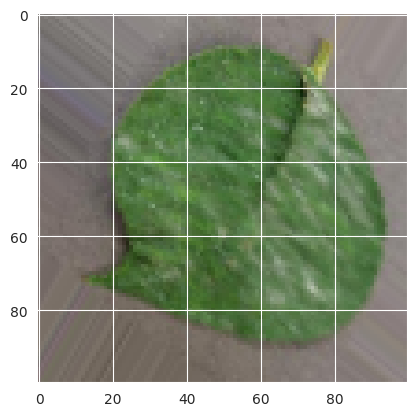

(20, 100, 100, 3)


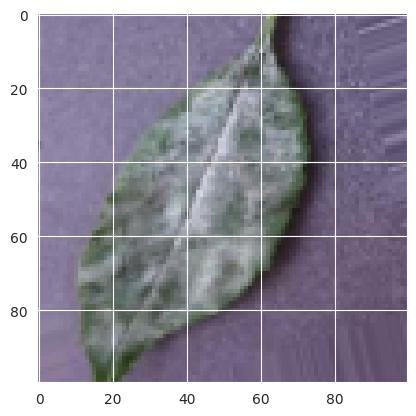

(20, 100, 100, 3)


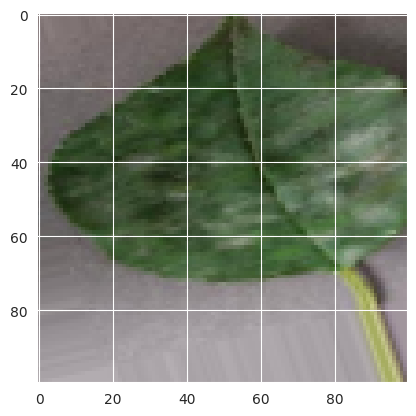

In [14]:
#Preview samples of augmented data
for _ in range(3):
    img, label = augmented_training_data.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

---

# Model

### Create CNN architecture

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras import regularizers


In [16]:
#Chose filters arbitrarily and tried a few combinations to finaly settle on the following setup.
# Initialy set kernel size to 3, 3 for all layers and increased to 5,5 based on reading this article: "https://towardsdatascience.com/deciding-optimal-filter-size-for-cnns-d6f7b56f9363"
#Chose to approach this as a 2 class categorical problem and using softmax as an activation function in the output layer

model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(5, 5),
          input_shape=img_shape, activation='relu', ))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=32, kernel_size=(5, 5),
          input_shape=img_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=16, kernel_size=(5, 5),
          input_shape=img_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
#apply regulization in order to prevent overfitting like explained in https://www.youtube.com/watch?v=aner3u79IGw
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

#apply dropout with p 0.5 in order to handle overfitting like explained in https://www.youtube.com/watch?v=UcKPdAM8cnI&t=201s
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

#Choose categorical crossentropy as a loss function to stick with the framing of the problem as categorical
#Choose to go with adam as a starting point for optimizer based on "https://towardsdatascience.com/7-tips-to-choose-the-best-optimizer-47bb9c1219e"
#As results where good. Did not experience the need to try to optimize through trial and error.
# Optimized for accuracy as business goal was accuracy above 97% explicitly.
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


2023-06-26 10:59:47.337209: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 16)        1216      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 44, 32)        12832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 18, 16)        12816     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1296)              0

### Model training

* Create callback Early stopping to stopp model training based on the validation loss
I. e. when validation loss fail to improve over epochs

In [18]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=4)

* Fit the model

In [19]:
#fit the model to the training data with augmentation
model.fit(augmented_training_data,
          epochs=25,
          validation_data=validation_data_object,
          callbacks=[early_stop],
          verbose=1
          )

2023-06-26 10:59:47.835103: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25
148/148 [==============================] - 23s 149ms/step - loss: 0.8940 - accuracy: 0.8223 - val_loss: 0.3493 - val_accuracy: 0.9123
Epoch 2/25
148/148 [==============================] - 20s 138ms/step - loss: 0.3627 - accuracy: 0.9108 - val_loss: 0.2033 - val_accuracy: 0.9787
Epoch 3/25
148/148 [==============================] - 25s 170ms/step - loss: 0.2417 - accuracy: 0.9447 - val_loss: 0.1414 - val_accuracy: 0.9905
Epoch 4/25
148/148 [==============================] - 25s 168ms/step - loss: 0.2417 - accuracy: 0.9417 - val_loss: 0.2826 - val_accuracy: 0.8910
Epoch 5/25
148/148 [==============================] - 23s 154ms/step - loss: 0.1508 - accuracy: 0.9685 - val_loss: 0.0871 - val_accuracy: 0.9905
Epoch 6/25
148/148 [==============================] - 34s 233ms/step - loss: 0.1726 - accuracy: 0.9583 - val_loss: 0.0675 - val_accuracy: 0.9976
Epoch 7/25
148/148 [==============================] - 36s 240ms/step - loss: 0.1074 - accuracy: 0.9834 - val_loss: 0.0909 - val_ac

### Show Training History

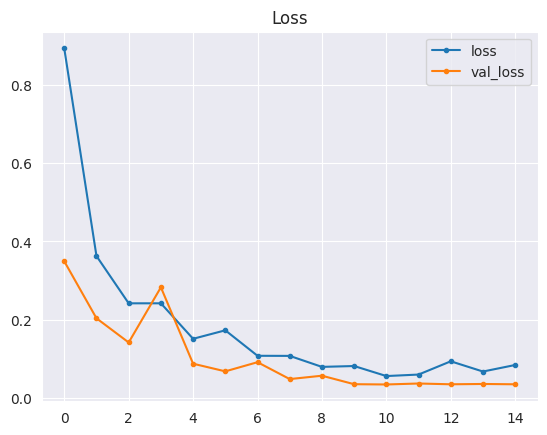

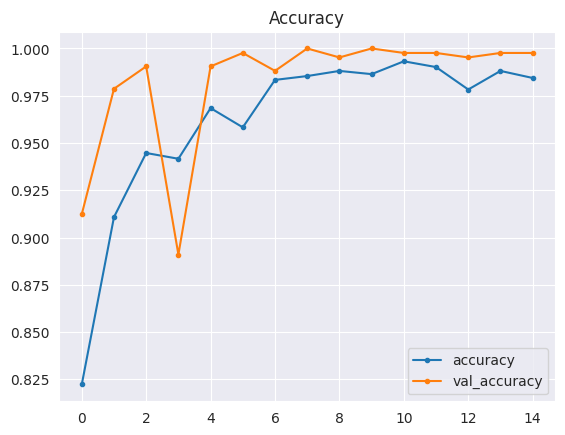

In [20]:
#extract the model training history to a variable
losses = pd.DataFrame(model.history.history)

#Plot training loss and validation loss over the epochs
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{version_output}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()


#Plot training accuracy and validation accuracy over the epochs
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{version_output}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()

---

# Evaluation

### Run model evaluation to see model performance on the test data

In [21]:
import pickle

evaluation = model.evaluate(test_data_object)
print(evaluation)

#Create a dictionary and pickle the performance metrics for app
evaluation_score = {}
evaluation_score[f'Loss'] = evaluation[0]
evaluation_score[f'Accuracy'] = evaluation[1]


with open('/workspace/Mildew-Detection-in-Cherry-Leaves/outputs/current_output/evaluation_report.pkl', 'wb') as file:
    pickle.dump(evaluation_score, file)

42/42 [==============================] - 1s 32ms/step - loss: 0.0358 - accuracy: 0.9976
[0.03579583019018173, 0.9976133704185486]


### Review model performance through Confusion Matrix and Classification reports

In [22]:
from sklearn.metrics import classification_report, confusion_matrix

def create_evaluation_report(data_object, data_name):
    #Create empty arrays to store the images and labels in formats compatible for the model
    img_arrays = []
    img_labels = []
    i = 0
    #Populate the arrays with the data from the data objects 
    while i < data_object.n:
        x_batch, y_batch = data_object.next()
        img_arrays.append(x_batch)
        img_labels.append(y_batch)
        i += x_batch.shape[0]
    img_arrays = np.concatenate(img_arrays, axis=0)
    img_labels = np.concatenate(img_labels, axis=0)

    #Create predictions
    prediction = model.predict(img_arrays)

    #Convert categorical predictions and actual value formats to binary formats
    prediction_binary = np.argmax(prediction, axis=1)
    img_labels_binary = np.argmax(img_labels, axis=1)

    #Create array holding arrays containing the index and the raw format prediction, for each false prediction the model made
    false_predictions = []
    for j in range(len(prediction_binary)):
        if prediction_binary[j] != img_labels_binary[j]:
            false_predictions.append([j, prediction[j]])

    #Print the confusion matrix and classification report for the dataset 
    print(f'--- {data_name}')
    print(f'Confusion Matrix --------------------------------')
    print(pd.DataFrame(confusion_matrix(y_true=prediction_binary, y_pred=img_labels_binary),
          columns = [["Actual " + sub for sub in labels]], 
          index = [["Prediction " + sub for sub in labels]]
          ))
    print("\n")

    print('Classification Report ----------------------------')
    print(classification_report(img_labels_binary, prediction_binary, target_names=labels),"\n")
    print("\n")
    #Return the all the predictions, as well as the array of false predictions
    return prediction, false_predictions


In [23]:
#Use data objects to pass into evaluation function, creating confusion matrix and classification report.
#Training set is used without transformations in augmentation
predicted_training = create_evaluation_report(training_data_object, 'TRAINING DATA')
predicted_validation = create_evaluation_report(validation_data_object, 'VALIDATION DATA')
predicted_test = create_evaluation_report(test_data_object, 'TEST DATA')

2023-06-26 11:07:02.331985: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 353760000 exceeds 10% of free system memory.


--- TRAINING DATA
Confusion Matrix --------------------------------
                          Actual healthy Actual powdery_mildew
Prediction healthy                  1470                     5
Prediction powdery_mildew              4                  1469


Classification Report ----------------------------
                precision    recall  f1-score   support

       healthy       1.00      1.00      1.00      1474
powdery_mildew       1.00      1.00      1.00      1474

      accuracy                           1.00      2948
     macro avg       1.00      1.00      1.00      2948
  weighted avg       1.00      1.00      1.00      2948
 



--- VALIDATION DATA
Confusion Matrix --------------------------------
                          Actual healthy Actual powdery_mildew
Prediction healthy                   210                     0
Prediction powdery_mildew              1                   211


Classification Report ----------------------------
                precision    recall

---

## Model Output

### Evaluate the significande of model probability output

In [24]:
from statistics import median


def check_probability_meaning(predicted_set, data_object, name):
    
    proba_for_all_pred = []
    n_predictions_below_threshold = []
    proba_for_false_pred = []

    for false_pred in predicted_set[1]:
        proba_for_false_pred.append(1 - min(false_pred[1]))

    #Calculate the 75th percentile of the probabilities false predictions
    # i.e where 75% of false predictions are below this probability
    threshold = np.quantile(proba_for_false_pred, [0.75])[0]

    #Collect all predictions that have a probability below the 75th percentile of false predictions
    for pred in predicted_set[0]:
        proba_for_all_pred.append(abs(1 - min(pred)))
        if abs(1 - min(pred)) < threshold:
            n_predictions_below_threshold.append(pred)

    
    #Calculate the % of predictions that are below the 75th percentile of false prediction
    ratio = round(((len(n_predictions_below_threshold) / data_object.n)*100),2)
    
    # add a report
    probability_report[f'{name}'] = {'threshold': round(threshold*100, 2), 'ratio': ratio}
    
    #Create figure to plot distribution of predictions across probabilities
    bin = []
    for i in range(25, 51):
        if i == 0 :
            bin.append(0)
        else:
            bin.append(i/50)

    fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
    axes[0].hist(proba_for_all_pred, bins=bin)
    axes[0].set_title('All predictions')
    axes[1].hist(proba_for_false_pred, bins=bin)
    axes[1].set_title('False predictions')
    fig.suptitle(f'Distribution of probabilities "{name}"', fontsize=16, y=1)
    plt.savefig(f'{version_output}/proba_dist_{name.lower()}.png',
            bbox_inches='tight', dpi=150)
    plt.show()



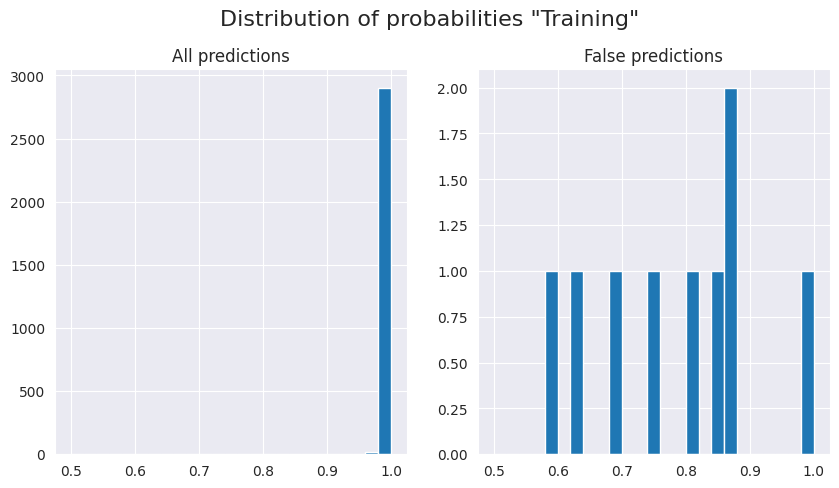

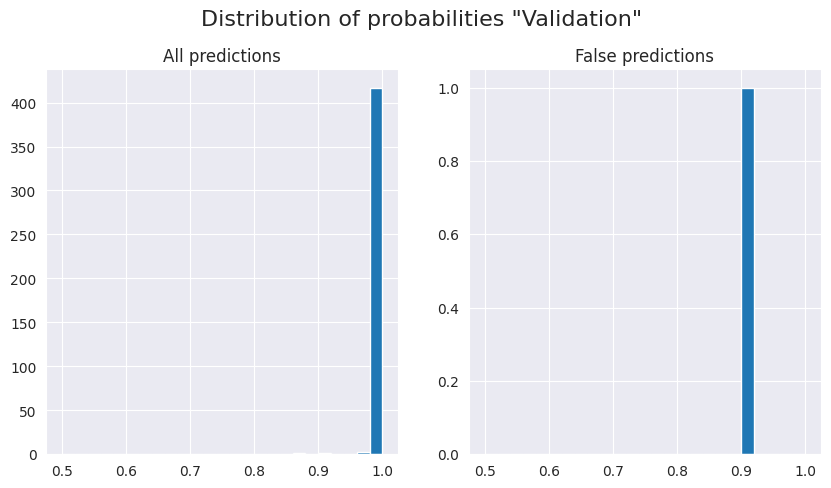

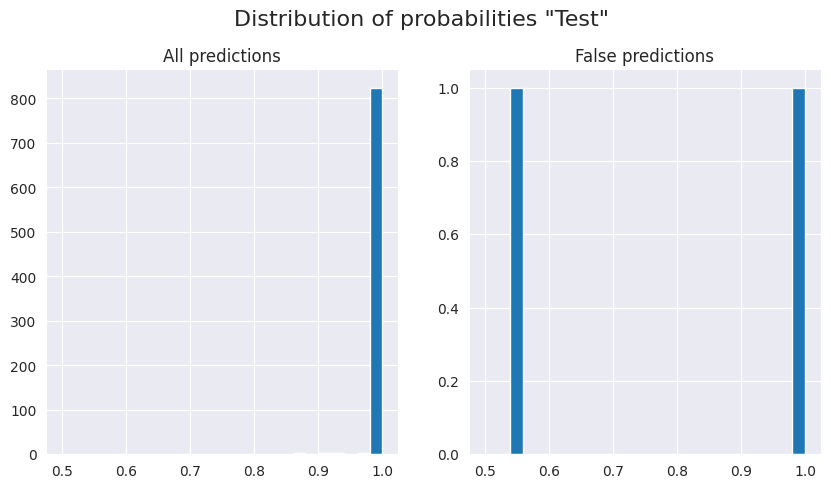

In [25]:
#Create dictionary to store probability metrics for each dataset
probability_report = {}

#create reports and plots for each dataset
check_probability_meaning(predicted_training, training_data_object, 'Training')
check_probability_meaning(predicted_validation, validation_data_object, 'Validation')
check_probability_meaning(predicted_test, test_data_object, 'Test')

#save reports to pickle file
with open('/workspace/Mildew-Detection-in-Cherry-Leaves/outputs/current_output/proba_report.pkl', 'wb') as file:
    pickle.dump(probability_report, file)

---

## Save the fitted model to folder

In [26]:
model.save(version_output + '/mildew_detection_model.h5')

---

# Conclusions and Next Steps

* Image montage on augmented data looks like a good representation of the dataset.
* Learning curve indicating loss and accuracy for train and validation seems to indicate that the model was able to learn to classify leaves correctly, without overfitting.
* Evaluation shows that the model meets business requirements. Hence, hypothesis 2 is confirmed.
* Probability examination seems to indicate that probability assigned to a prediction gives some indication of wether it is correct or not.
  * The evidense for this is very week, at best. And hypothesis 3 can not be confirmed based on these findings.